In [87]:
import string

import numpy as np

import pandas as pd

from joblib import Parallel, delayed
from tqdm import tqdm

from rdmc.mol import RDKitMol
from rdkit.Chem.Descriptors import ExactMolWt, NumRadicalElectrons
from rdkit.Chem.rdMolDescriptors import CalcNumRings, CalcNumHBD, CalcNumHeavyAtoms, CalcNumRotatableBonds
from rdkit.Chem import GetPeriodicTable

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Plot descriptor distribution

- Add radical center atom type

In [33]:
radical_resonance_df = pd.read_csv("../data/radical_resonance.csv")

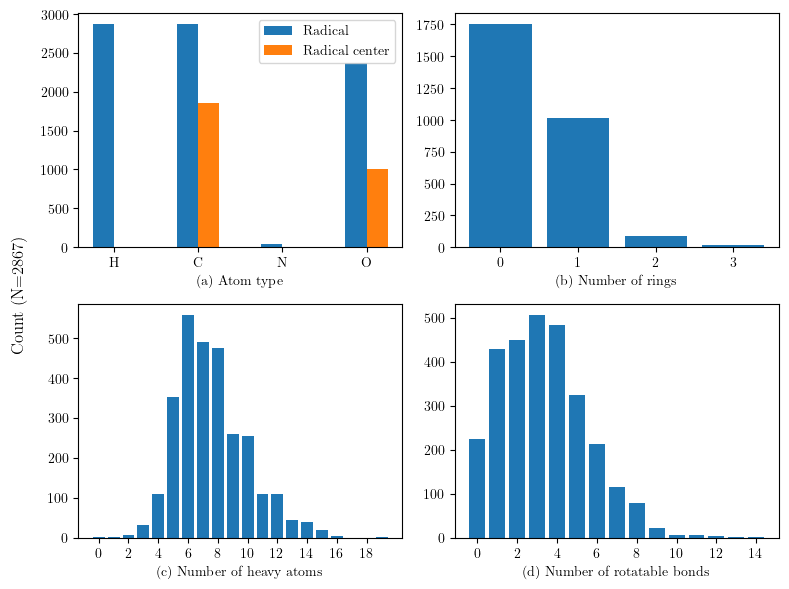

In [92]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

ax = axs.flat[0]
width = 0.25
atom_symbol_columns = [column for column in radical_resonance_df.columns if "has_" in column]
atom_symbols = [column.split("has_")[1] for column in atom_symbol_columns]
xs = np.array(range(len(atom_symbols)))
counts = radical_resonance_df["radical_atom_type"].value_counts()
ax.bar(xs, radical_resonance_df[atom_symbol_columns].sum(axis=0), width=width, label="Radical")
ax.bar(xs+width, [counts[atom_symbol] for atom_symbol in atom_symbols], width=width, label="Radical center")
ax.set_xticks(xs+width/2)
ax.set_xticklabels(atom_symbols)
ax.set_xlabel("(a) Atom type")
ax.legend()

ax = axs.flat[1]
counts = radical_resonance_df["num_rings"].value_counts()
xs = range(counts.index.max()+1)
ys = [counts[x] for x in xs]
ax.bar(xs, ys)
ax.set_xlabel("(b) Number of rings")

ax = axs.flat[2]
counts = radical_resonance_df["num_heavy_atoms"].value_counts()
xs = range(counts.index.max()+1)
ys = [counts.get(x, 0.0) for x in xs]
ax.bar(xs, ys)
ax.set_xticks(xs[::2])
ax.set_xlabel("(c) Number of heavy atoms")

ax = axs.flat[3]
counts = radical_resonance_df["num_rotatable_bonds"].value_counts()
xs = range(counts.index.max()+1)
ys = [counts.get(x, 0.0) for x in xs]
ax.bar(xs, ys)
ax.set_xticks(xs[::2])
ax.set_xlabel("(d) Number of rotatable bonds")

fig.supylabel(f"Count (N={len(radical_resonance_df.index)})")
fig.tight_layout()
fig.savefig("figures/data_radical_descriptors_hist.pdf", bbox_inches="tight")

# Plot HBI distribution

In [51]:
HBI_correction_df = pd.read_csv("../data/hbi.csv")
HBI_correction_df

,radical_smiles,radical_resonance_smiles,closed_shell_smiles,closed_shell_H298 (kcal/mol),closed_shell_S298 (cal/mol/K),closed_shell_Cp300 (cal/mol/K),closed_shell_Cp400 (cal/mol/K),closed_shell_Cp500 (cal/mol/K),closed_shell_Cp600 (cal/mol/K),closed_shell_Cp800 (cal/mol/K),...,radical_num_resonance,HBI_H298 (kcal/mol),HBI_Sint298 (cal/mol/K),HBI_Cp300 (cal/mol/K),HBI_Cp400 (cal/mol/K),HBI_Cp500 (cal/mol/K),HBI_Cp600 (cal/mol/K),HBI_Cp800 (cal/mol/K),HBI_Cp1000 (cal/mol/K),HBI_Cp1500 (cal/mol/K)
0,[O]C(=O)OC(O)(O)O,[O]C(=O)OC(O)(O)O,O=C(O)OC(O)(O)O,-272.617591,98.406448,31.562314,36.827897,41.095602,44.234417,48.821415,...,1,49.103465,-4.589644,2.364565,1.559776,0.412894,-0.172027,-1.041685,-1.683176,-3.705453
1,[O]C(O)(O)OC(=O)O,[O]C(O)(O)OC(=O)O,O=C(O)OC(O)(O)O,-272.617591,98.406448,31.562314,36.827897,41.095602,44.234417,48.821415,...,1,49.194200,-7.808181,0.968866,0.741762,0.402841,0.476043,0.534574,0.412253,-1.394250
2,O=C(O)O[C](O)O,O=C(O)O[C](O)O,O=C(O)OC(O)O,-231.363843,94.127419,27.214474,31.965583,36.032333,39.309560,44.059044,...,1,44.040974,-4.610350,1.758768,2.587490,2.714389,2.346110,1.178471,0.282207,-0.997631
3,CC(=O)OC(OO)C(=O)C(O)O[O],CC(=O)OC(OO)C(=O)C(O)O[O],CC(=O)OC(OO)C(=O)C(O)OO,-234.219312,145.598548,52.706616,62.438776,71.442505,78.070363,87.443365,...,1,48.558735,-12.393484,3.863088,3.589450,2.161239,1.702481,1.262146,-0.928170,-3.176204
4,O=[C]OC(O)(O)O,O=[C]OC(O)(O)O,O=COC(O)(O)O,-216.499044,92.684651,26.935163,30.962696,34.637667,37.592447,42.375430,...,1,36.001481,-4.835845,5.443029,5.881647,4.696512,3.708683,1.768296,0.144000,-3.234417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,C1=C[CH]C=1,[C]1=CC=C1,C1=CC=C1,104.333500,57.818020,15.504000,19.920000,23.474000,26.261000,30.329000,...,2,51.773082,3.435468,-0.850889,-1.431243,-1.911856,-2.405821,-3.006968,-3.449835,-4.556360
2863,C=C=C1C=[C]C1,C=C=C1C=[C]C1,C=C=C1C=CC1,91.366874,50.394958,22.416919,29.489266,35.000461,39.185145,45.162263,...,1,66.366211,25.815240,0.258337,-1.155381,-2.024215,-2.373362,-2.314548,-2.090808,-2.168527
2864,[CH2]C1=CC#CC1,[CH2]C1=CC#CC1,CC1=CC#CC1,131.227000,72.956831,23.409000,30.017000,34.619000,39.828000,46.529000,...,3,32.271344,0.823844,-0.802362,-1.521882,-1.227900,-2.500041,-3.127836,-3.711522,-2.960733
2865,[CH2]C1=CC#CC1,C=C1[CH]C#CC1,C=C1CC#CC1,136.767000,72.435147,22.819000,29.017000,34.189000,38.448000,45.419000,...,3,26.731344,0.773844,-0.212362,-0.521882,-0.797900,-1.120041,-2.017836,-2.931522,-2.570733


In [53]:
Ts = [300, 400, 500, 600, 800, 1000, 1500]

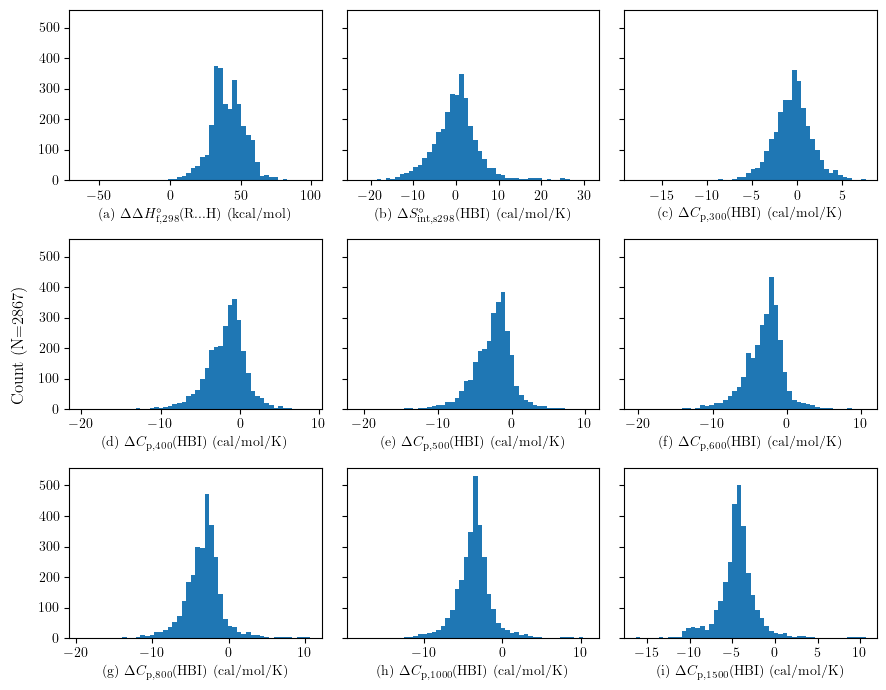

In [58]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 7))
ax = axs.flat[0]
ax.hist(HBI_correction_df["HBI_H298 (kcal/mol)"], bins=50)
ax.set_xlabel("(a) $\Delta \Delta H^\circ_\mathrm{f,298}$(R...H) (kcal/mol)")

ax = axs.flat[1]
ax.hist(HBI_correction_df["HBI_Sint298 (cal/mol/K)"], bins=50)
ax.set_xlabel("(b) $\Delta S^\circ_\mathrm{int,s298}$(HBI) (cal/mol/K)")

for ax, T, alph in zip(axs.flat[2:], Ts, list(string.ascii_lowercase)[2:]):
    ax.hist(HBI_correction_df[f"HBI_Cp{T} (cal/mol/K)"], bins=50)
    ax.set_xlabel(f"({alph}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$(HBI) (cal/mol/K)")

fig.supylabel(f'Count (N={len(HBI_correction_df.index)})')
fig.tight_layout()
fig.savefig(f"figures/data_hbi_hist.pdf", bbox_inches="tight")